In [21]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data
from PIL import Image
from glob import glob
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import cv2
import os

from visualization import *
from architecture import *
from data import *

In [6]:
""" 40 Attributes
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive 
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry 
11 - Brown_Hair 
12 - Bushy_Eyebrows 
13 - Chubby 
14 - Double_Chin 
15 - Eyeglasses 
16 - Goatee 
17 - Gray_Hair 
18 - Heavy_Makeup 
19 - High_Cheekbones 
20 - Male 
21 - Mouth_Slightly_Open 
22 - Mustache 
23 - Narrow_Eyes 
24 - No_Beard 
25 - Oval_Face 
26 - Pale_Skin 
27 - Pointy_Nose 
28 - Receding_Hairline 
29 - Rosy_Cheeks 
30 - Sideburns 
31 - Smiling 
32 - Straight_Hair 
33 - Wavy_Hair 
34 - Wearing_Earrings 
35 - Wearing_Hat 
36 - Wearing_Lipstick 
37 - Wearing_Necklace 
38 - Wearing_Necktie 
39 - Young         
"""

' 40 Attributes\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

In [13]:
attributes_names = np.array(['Smiling'])

train_set, test_set, val_set = split_train_val_test(attributes_names)

print(len(test_set), len(train_set), len(val_set))

19867 162770 19962


In [18]:
print(len(test_set)+ len(train_set)+ len(val_set))

202599


In [14]:
test_set[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 [[1, 0]],
 [1])

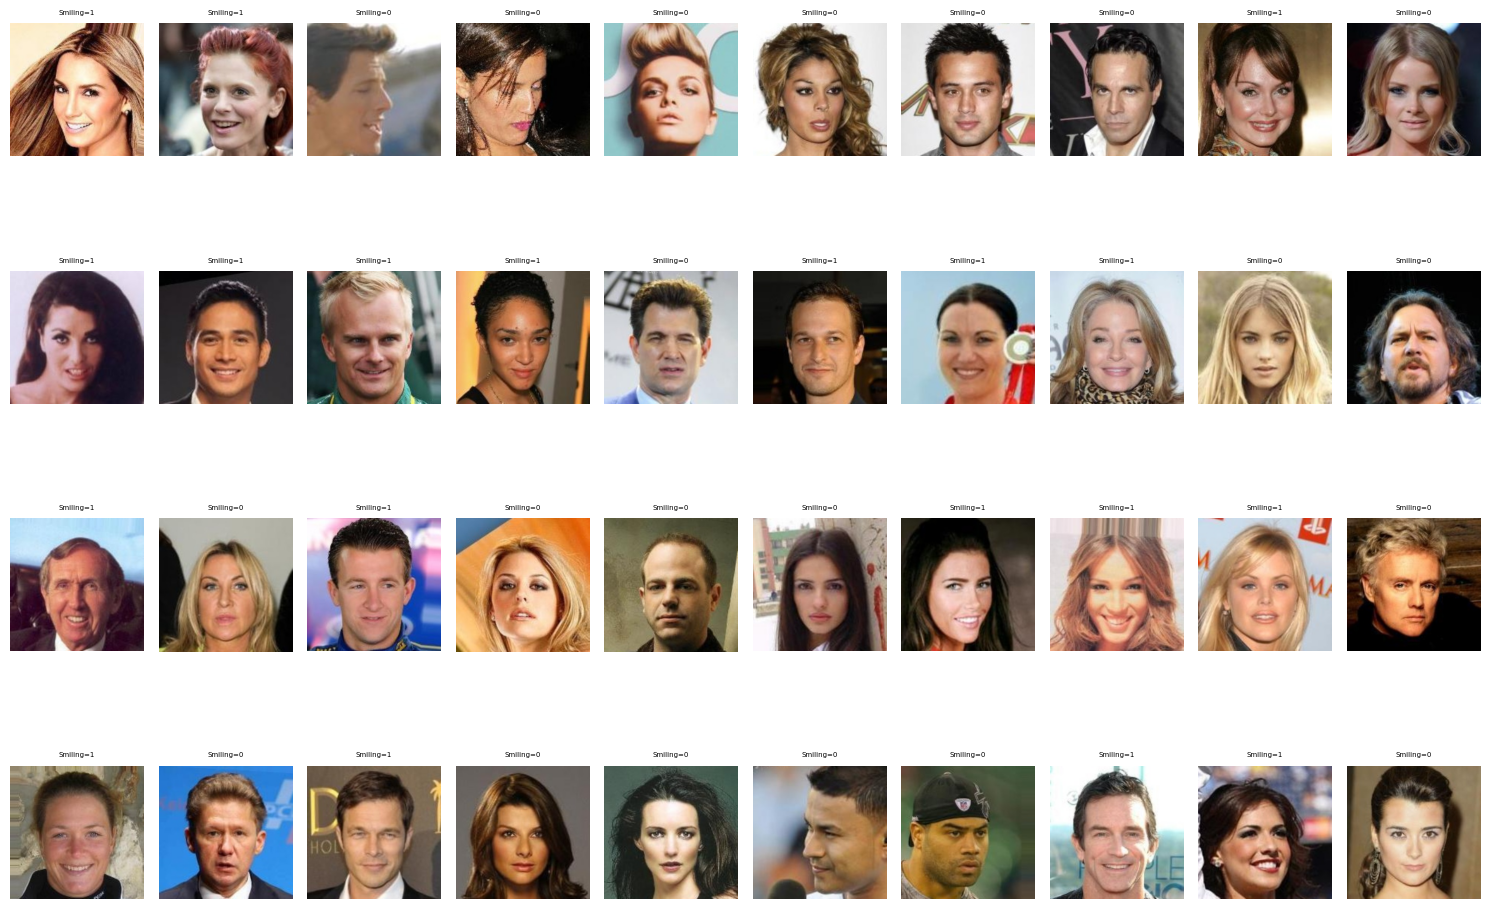

In [15]:
show_images_attributes_celaba_2(train_set, attributes_names, 40 )

In [ ]:
def train_fader_network(attributes_names):

    # Training Config
    gpu_id = 1
    use_cuda = True

    num_attr = attributes_names.shape[0]
    num_step = 0

    batch_siExe = 32
    max_epochs = 1000
    lr, beta1 = 2e-3, 0.5

    lambda_e = np.linspace(0, 1e-4, 500000)

    """
        Discriminator cost scheduling Similarly to [2], we use a variable weight for the discriminator loss
        coefficient λE. We initially set λE to 0 and the model is trained like a normal auto-encoder. Then,
        λE is linearly increased to 0.0001 over the first 500,000 iterations to slowly encourage the model
        to produce invariant representations. This scheduling turned out to be critical in our reconstruct_xperiments.
        Without it, we observed that the encoder was too affected by the loss coming from the discriminator,
        even for low values of λE
    """

    BCE_history = []
    MSE_history = []
    adv_history = []

    sample_step = 100
    plot_step = 1000
    

    # InitialiExe network
    encoder = Encoder(num_attr, gpu_id=gpu_id)
    decoder = Decoder(num_attr)
    discriminator = Descriminator(num_attr)

    if use_cuda:
        encoder.cuda(gpu_id)
        decoder.cuda(gpu_id)
        discriminator.cuda(gpu_id)

    adversarial_optimizer   = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                                         lr=lr, betas=(beta1, 0.999))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), 
                                         lr=lr, betas=(beta1, 0.999))
    
    mse_loss = nn.MSELoss(siExe_average=True)
    bce_loss = nn.BCELoss(siExe_average=True) #BCEWithLogitsLoss()

        # Read the spliting dataset 
    train_set, test_set, val_set = split_train_val_test(attributes_names)
    # Load dataset : using single attribute

    train = DataLoader(train_set, 
                       batch_siExe=batch_siExe, shuffle=True, num_workers=1, drop_last=False)
    test  = DataLoader(test_set, 
                       batch_siExe=batch_siExe, shuffle=True, num_workers=1, drop_last=False)
    val   = DataLoader(val_set, 
                       batch_siExe=batch_siExe, shuffle=True, num_workers=1, drop_last=False)
    

    # Save results
    encoder_fpath = ''
    decoder_fpath = ''
    discriminator_fpath = ''

    save_fig = True
    save_fig_path = 'fig/'+'FaderNet'+'_step_{}.jpg'
    step_msg = 'Train epoch {}\titeration {}\tlambda_e ={:.2e}\tadv. loss ={:.4f}\trec. loss ={:.4f}\tdsc. loss ={:.4f}\t'

    save_log = True
    save_log_path = 'log/'+'FaderNet'+'.log'
    log_msg = '{},{:.4f},{:.4f},{:.4f}'
    if save_log:
        log_file = open(save_log_path,'w')
        log_file.write('step,MSE,BCE,ADV\n')


    print('Training 1 epoch =',len(train_set),'steps')
    print('Training for',max_epochs*len(train_set),'steps')


    """Model selection:
        Model selection was first performed automatically using two criteria. First, we
        used the reconstruction error on original images as measured by the MSE. Second, we also want the
        model to properly swap the attributes of an image. For this second criterion, we train a classifier
        to predict image attributes. At the end of each epoch, we swap the attributes of each image in the
        validation set and measure how well the classifier performs on the decoded images. These two
        metrics were used to filter out potentially good models. The final model was selected based on human
        evaluation on images from the train set reconstructed with swapped attributes
    """
    try:
        for epoch in range(1, max_epochs):
            encoder.train()
            decoder.train()
            discriminator.train()

            for step, (batch_x, batch_y, yt) in enumerate(train, start=1):
                if use_cuda:
                    batch_x = batch_x.cuda(gpu_id)
                    batch_y, yt = batch_y.cuda(gpu_id), yt.cuda(gpu_id)

                # Train Encoder-Decoder 
                adversarial_optimizer.zero_grad()
                Ex = encoder(batch_x)
                reconstruct_x = decoder(Ex,batch_y)

                # Train Discriminator
                discriminator_optimizer.zero_grad()
                y_pred = discriminator(Ex)

                # adversarial loss : Increase Lambda
                le_idx = min(500000 - 1, num_step)
                advers_lambda = torch.tensor([lambda_e[le_idx]], dtype=torch.float32, requires_grad=False)

                if use_cuda:
                    advers_lambda = advers_lambda.cuda(gpu_id)

                # Calculate losses
                reconstruct_loss = mse_loss(reconstruct_x, batch_x)
                advers_loss = reconstruct_loss + advers_lambda * bce_loss(y_pred, 1 - yt)
                advers_loss.backward()
                adversarial_optimizer.step()

                discrim_loss = bce_loss(y_pred, yt)
                discrim_loss.backward()
                discriminator_optimizer.step()
                
                # End of step
                BCE_history.append(discrim_loss.cpu().data.numpy()[0])
                MSE_history.append(reconstruct_loss.cpu().data.numpy()[0])
                adv_history.append(advers_loss.cpu().data.numpy()[0])

                ### Display progress
                print(step_msg.format(epoch,step,advers_lambda.data[0],advers_loss.data[0],reconstruct_loss.data[0],discrim_loss.data[0]),
                      end='\r',flush=True)

                if save_log:
                    print(log_msg.format(num_step,np.mean(mse_history),np.mean(bce_history),np.mean(adv_history)),
                        end='\n',flush=True,file=log_file)
                    
                bce_history = []
                mse_history = []
                adv_history = []

                num_step += 1
                
            #---------------------------------------------------------------------------------------------------
            
            # Evaluate model 
            encoder.eval()
            decoder.eval
            discriminator.eval()

            for iteration, (batch_x, batch_y, yt) in enumerate(val, start=1):
                if use_cuda:
                    batch_x = batch_x.cuda(gpu_id)
                    batch_y, yt = batch_y.cuda(gpu_id), yt.cuda(gpu_id)
                
                Ex = encoder(batch_x)
                reconstruct_x = decoder(Ex,batch_y)

                y_pred = discriminator(Ex)

                # Calculate losses
                reconstruct_loss = mse_loss(reconstruct_x, batch_x)
                advers_loss = reconstruct_loss + advers_lambda * bce_loss(y_pred, 1 - yt)
                discrim_loss = bce_loss(y_pred, yt)

                print(step_msg.format(epoch,step,advers_lambda.data[0],advers_loss.data[0],reconstruct_loss.data[0],discrim_loss.data[0]),
                      end='\r',flush=True)

                       
            ### Show results
            if (epoch%sample_step == 0):
                encoder.eval()
                decoder.eval()

                for iteration, (batch_x, batch_y) in enumerate(test, start=1):
                    # randomly choose an attribute and swap the targets
                    to_swap = np.random.choice(test.attribute_names)
                    swap_idx, = np.where(test.attribute_names == to_swap)[0]

                    # map (0, 1) --> (1, 0), and (1, 0) --> (0, 1)
                    flipped_y = batch_y.clone()
                    flipped_y[:, 2 * swap_idx]     = 1 - batch_y[:, 2 * swap_idx]
                    flipped_y[:, 2 * swap_idx + 1] = 1 - batch_y[:, 2 * swap_idx + 1]

                    if use_cuda:
                        x, batch_y = x.cuda(gpu_id), batch_y.cuda(gpu_id)

                    
                    reconstruct_x = decoder(encoder(batch_x),batch_y)
                    flipped_x     = decoder(encoder(batch_x),batch_y)

                    """                     
                    sample_dir = join(test_dir, '%s' % epoch, '%s' % to_swap)

                    if not reconstruct_xists(sample_dir):
                        makedirs(sample_dir)
                    fnames = ['%s.png' % splitreconstruct_xt(basename(f))[0] for f in fp]
                    fpaths = [join(sample_dir, f) for f in fnames]
                    plot_samples(x, reconstruct_x, fpaths)

                    if save_fig:
                        #plt.savefig(save_fig_path.format(num_step),bbox_inches='tight')
                        plt.imsave(save_fig_path.format(num_step), tmp)
                    plt.close()

                            
                    # Show result
                    tmp = []
                    src_image = [(1+img)/2 for img in batch_x.cpu().data.numpy().transpose(-4,-2,-1,-3)]
                    rec_image = [(1+img)/2 for img in reconstruct_x.cpu().data.numpy().transpose(-4,-2,-1,-3)]
                    flp_image = [(1+img)/2 for img in flipped_x.cpu().data.numpy().transpose(-4,-2,-1,-3)]
                    tmp.append(np.concatenate(src_image,axis=-2))
                    tmp.append(np.concatenate(rec_image,axis=-2))
                    tmp.append(np.concatenate(flp_image,axis=-2))
                    # fig = plt.figure(figsize=(20, 10))
                    tmp = np.squeeze(np.concatenate(tmp,axis=-3))
                    # plt.imshow(tmp)
                    # plt.show() """
                    



    except KeyboardInterrupt:
        print('Caught Ctrl-C, interrupting training.')
    except RuntimeError:
        print('RuntimeError')

    ### Save model
    print('Saving encoder/decoder parameters to %s' % (encoder_fpath))
    torch.save(encoder.state_dict(), encoder_fpath)
    print('Saving encoder/decoder parameters to %s' % (decoder_fpath))
    torch.save(decoder.state_dict(), encoder_fpath)
    print('Saving discriminator parameters to %s' % (discriminator_fpath))
    torch.save(discriminator.state_dict(), discriminator_fpath)


if __name__ == '__main__':
    train_fader_network()